<a href="https://colab.research.google.com/github/Saf02Sam/general/blob/main/Saffa_Samreen_assignment1_problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem1—Creating a simple neural network for regression

Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


Initializing parameters

In [ ]:
"""
nx is the number of neurons in the input layer (i.e., the number of features in the dataset)
nh is the number of neurons in the hidden layer
ny is the number of neurons in the output layer (For this example we are using one nueron in the output layer so ny=1)
"""
def initialize_parameters(nx,nh,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)

    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays
    W1=tf.Variable(tf.random.uniform(shape=(nh,nx), minval=-0.01, maxval=0.01), name="W1")
    b1=tf.Variable(tf.zeros(shape=(nh,1),name="b1" ))
    W2=tf.Variable(tf.random.uniform(shape=(ny,nh), minval=-0.01, maxval=0.01), name="W2")
    b2=tf.Variable(tf.zeros(shape=(ny,1), name="b2"))

    #create a dictionary of network parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

Forward Pass

In [ ]:
"""
In forward pass we do the computations in the computational graph. We cache the intermediate nodes we will later need in the backward pass
"""
def forward_pass(parameters,X):
    #the input image is read as an integer, use tf.cast to cast it to float before using it in fowrard pass computation.
    X= tf.cast(X, tf.float32)
    #not using any activation function because this is a regression problem
    Z1= tf.matmul(parameters["W1"],X)+ parameters["b1"]
    A1=Z1
    Z2=tf.matmul(parameters["W2"],A1)+parameters["b2"]

    Yhat=Z2
    # Print intermediate values
    #print("Z1:", Z1)
    #print("A1:", A1)
    #print("Z2:", Z2)
    #print("Yhat:", Yhat)

    return Yhat


Computing loss

In [ ]:
"""
n is the number of examples, y is a vector of actual/observed outputs and yhat is a vector of predicted outputs
"""
def compute_loss(Y,Yhat):
  #print("Y:", Y)
  #print("Yhat:", Yhat)
  per_sample_losses = abs(Y-Yhat)

  loss=tf.reduce_mean(per_sample_losses)
    #print("Loss:", loss)
  return loss




Backward Pass

In [ ]:
def backward_pass(parameters, loss, tape):
    gradients= tape.gradient(loss,parameters)
    #print("gradients:", gradients)
    return gradients


Updating parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"].assign_sub(learning_rate*gradients["W1"])
    parameters["W2"].assign_sub(learning_rate*gradients["W2"])
    parameters["b1"].assign_sub(learning_rate*gradients["b1"])
    parameters["b2"].assign_sub(learning_rate*gradients["b2"])
    return parameters

Creating the neural network model

In [ ]:
"""
Arguments: train_X: is the training dataset (features)
           train_Y: is the vector of labels for training_X
           val_X: is the vector of validation dataset (features)
           val_y: is the vector of labels for val_X
           nh: is the number of neurons in the hidden layer
           num_iterations: The number of iterations of gradient descent
"""
def create_nn_model(train_X,train_Y, val_X, val_Y,nh, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for regression, so we have only one neuron in the output layer with no activation
    ny=1

    # initializing the parameteres
    parameters=initialize_parameters(nx,nh,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
        run forward pass and compute the loss function on training and validation data.
        Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
        The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
        """

      with tf.GradientTape() as tape:
        train_Yhat=forward_pass(parameters,train_X)
        train_loss=compute_loss(train_Y,train_Yhat)


       #compute validation loss
      Yhat_val= forward_pass(parameters,val_X)
      val_loss=compute_loss(val_Y,Yhat_val)

      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss,val_loss))

       # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)

      """
      Compute the gradients and update the parameters
      """
      #compute the gradients on the training data
      gradients=backward_pass(parameters,train_loss,tape)

      # update the parameters
      parameters=update_parameters(parameters, gradients, learning_rate)



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history





Predicting the output

In [ ]:
def predict(parameters,X, prob_threshold=0.5):
    Yhat=forward_pass(parameters, X)
    # predicted label is the same as predicted value, because this is a regression problem
    predicted_label=Yhat
    return predicted_label

Uploading the dataset

In [ ]:
# reading the input datasets train.csv and validation.csv
dataset=pd.read_csv("/content/Clean_Dataset.csv")
print(dataset.shape)

(300153, 12)


One hot encoding

In [ ]:
#Processing categorical data using one hot encoding
categorical_cols = dataset.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
threshold = 0.05
for col in categorical_cols:
    freq = dataset[col].value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index
    dataset[col] = dataset[col].replace(rare_categories, "Other")
    dataset[col] = dataset[col].replace(rare_categories, "Other")
    dataset[col] = dataset[col].replace(rare_categories, "Other")
dataset_encoded = pd.DataFrame(encoder.fit_transform(dataset[categorical_cols].astype(str)))
#test_encoded = pd.DataFrame(encoder.transform(test[categorical_cols].astype(str)))
#val_encoded = pd.DataFrame(encoder.transform(val[categorical_cols].astype(str)))

# Get feature names after encoding
categorical_cols_str = [str(col) for col in categorical_cols]
feature_names = encoder.get_feature_names_out(categorical_cols_str)
dataset_encoded.columns = feature_names
#test_encoded.columns = feature_names
#val_encoded.columns = feature_names

dataset_encoded = dataset_encoded.join(dataset.drop(columns=categorical_cols, axis=1))
#test_encoded = test_encoded.join(test.drop(columns=categorical_cols, axis=1))
#val_encoded = val_encoded.join(val.drop(columns=categorical_cols, axis=1))

print(dataset_encoded.head())


   airline_AirAsia  airline_Air_India  airline_GO_FIRST  airline_Indigo  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              1.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   airline_Other  airline_Vistara  flight_Other  source_city_Bangalore  \
0            1.0              0.0           1.0                    0.0   
1            1.0              0.0           1.0                    0.0   
2            0.0              0.0           1.0                    0.0   
3            0.0              1.0           1.0                    0.0   
4            0.0              1.0           1.0                    0.0   

   source_city_Chennai  source_city_Delhi  ...  destination_city_Delhi  \
0                  0.0        

Splitting dataset into train, test and validation

In [ ]:
#splitting into train, test and validation
train_test, val= train_test_split(dataset_encoded, test_size=0.2, random_state=1)
train, test= train_test_split(train_test, test_size=0.2, random_state=1)
print(train.shape)
print(test.shape)
print(val.shape)
#print(train.head())

(192097, 40)
(48025, 40)
(60031, 40)


Normalizaation and scaling

In [ ]:
#normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[train.columns] = scaler.fit_transform(train[train.columns])
test[test.columns] = scaler.transform(test[test.columns])
val[val.columns] = scaler.transform(val[val.columns])

#scaling target variable
train['price'] = scaler.fit_transform(train['price'].values.reshape(-1, 1))
test['price'] = scaler.transform(test['price'].values.reshape(-1, 1))
val['price'] = scaler.transform(val['price'].values.reshape(-1, 1))

In [ ]:
train=train.to_numpy()
test=test.to_numpy()
val=val.to_numpy()

Splitting into features and target

In [ ]:
train_X=train[:,:-1,]
test_X=test[:,:-1,]
val_X=val[:,:-1,]
train_Y=train[:, -1]
test_Y=test[:, -1]
val_Y=val[:, -1]

train_X=np.transpose(train_X)
val_X=np.transpose(val_X)
test_X=np.transpose(test_X)
train_Y=np.reshape(train_Y, (1,train_Y.size))
val_Y=np.reshape(val_Y, (1,val_Y.size))
test_Y=np.reshape(test_Y, (1,test_Y.size))
#train_Y=np.transpose(train_X)
#val_Y=np.transpose(val_X)


print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(val_X.shape)
print(val_Y.shape)

(39, 192097)
(1, 192097)
(39, 48025)
(1, 48025)
(39, 60031)
(1, 60031)


Training the model and computing loss

In [ ]:
iterations=1000
parameters, history=create_nn_model(train_X,train_Y, val_X, val_Y,100,iterations, 0.01)

iteration 0 :train_loss:0.8710129261016846 val_loss0.8688726425170898
iteration 1 :train_loss:0.8694311380386353 val_loss0.8672743439674377
iteration 2 :train_loss:0.8678706884384155 val_loss0.8656988143920898
iteration 3 :train_loss:0.8663241863250732 val_loss0.8641376495361328
iteration 4 :train_loss:0.8647802472114563 val_loss0.862579882144928
iteration 5 :train_loss:0.863237202167511 val_loss0.8610233664512634
iteration 6 :train_loss:0.8616973161697388 val_loss0.859469473361969
iteration 7 :train_loss:0.860162615776062 val_loss0.857921302318573
iteration 8 :train_loss:0.8586311340332031 val_loss0.8563764095306396
iteration 9 :train_loss:0.8571000099182129 val_loss0.8548319339752197
iteration 10 :train_loss:0.8555684089660645 val_loss0.8532875180244446
iteration 11 :train_loss:0.8540379405021667 val_loss0.8517444729804993
iteration 12 :train_loss:0.8525108098983765 val_loss0.850204348564148
iteration 13 :train_loss:0.8509848117828369 val_loss0.8486658334732056
iteration 14 :train_lo

Plotting the loss

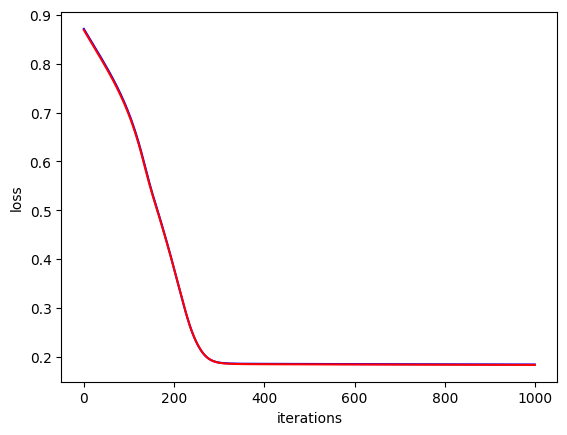

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

Calculating loss

In [ ]:

predicted_train=predict(parameters, train_X)
predicted_val=predict(parameters, val_X)

print("loss of the model on the training data is:", float(compute_loss(train_Y,predicted_train)))
print("loss of the model on the validation data is:", float(compute_loss(val_Y,predicted_val)))

loss of the model on the training data is: 0.18457378447055817
loss of the model on the validation data is: 0.18372111022472382


#training and hyper-parameter tuning

Increasing number of iterations because loss is still decreasing.

In [ ]:
iterations=20000
parameters, history=create_nn_model(train_X,train_Y, val_X, val_Y,100,iterations, 0.01)

Streaming output truncated to the last 5000 lines.
iteration 15000 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15001 :train_loss:0.18200863897800446 val_loss0.1812058687210083
iteration 15002 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15003 :train_loss:0.18200863897800446 val_loss0.1812058538198471
iteration 15004 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15005 :train_loss:0.18200863897800446 val_loss0.1812058687210083
iteration 15006 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15007 :train_loss:0.18200863897800446 val_loss0.1812058538198471
iteration 15008 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15009 :train_loss:0.18200863897800446 val_loss0.1812058538198471
iteration 15010 :train_loss:0.18200863897800446 val_loss0.1812058836221695
iteration 15011 :train_loss:0.18200863897800446 val_loss0.1812058538198471
iteration 15012 :train_loss:0.18200863897800446 v

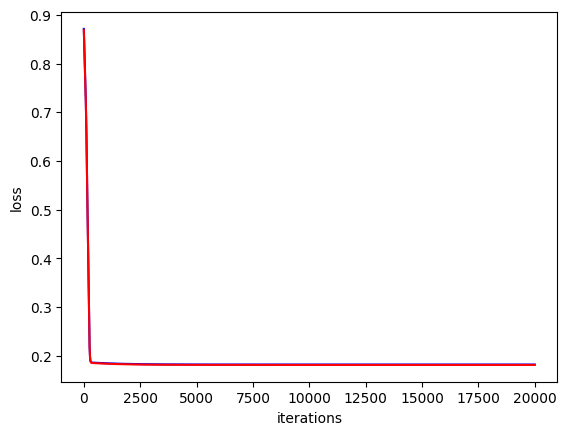

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [ ]:
predicted_train=predict(parameters, train_X)
predicted_val=predict(parameters, val_X)

print("loss of the model on the training data is:", float(compute_loss(train_Y,predicted_train)))
print("loss of the model on the validation data is:", float(compute_loss(val_Y,predicted_val)))

loss of the model on the training data is: 0.18200863897800446
loss of the model on the validation data is: 0.1812058836221695


#Modify the code such that the create_nn method can accept and train a neural network with any given number of hidden layers

Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt




Initializing parameters

In [ ]:
"""
nx is the number of neurons in the input layer (i.e., the number of features in the dataset)
nh is the number of neurons in the hidden layer
ny is the number of neurons in the output layer (For this example we are using one nueron in the output layer so ny=1)
"""


def initialize_parameters(nx,nh_array,ny):
    #set tensorflow global random seed
    tf.random.set_seed(1)
    parameters = dict()
    #initialize weights to small random numbers and biases to zeros for each layer. Note that weights and biases are defined as tensorflow variables instead of numpy arrays

    for i, element in enumerate(nh_array):
        parameters["W" + str(i + 1)] = tf.Variable(tf.random.uniform(shape=(element, nx if i == 0 else nh_array[i - 1]), minval=-0.01, maxval=0.01, name="W" + str(i + 1)))
        parameters["b" + str(i + 1)] = tf.Variable(tf.zeros(shape=(element, 1), name="b" + str(i + 1)))

    parameters["W" + str(len(nh_array) + 1)] = tf.Variable(tf.random.uniform(shape=(ny, nh_array[-1]), minval=-0.01, maxval=0.01), name="W" + str(len(nh_array) + 1))
    parameters["b" + str(len(nh_array) + 1)] = tf.Variable(tf.zeros(shape=(ny, 1)), name="b" + str(len(nh_array) + 1))


    parameters["Wo"]=tf.Variable(tf.random.uniform(shape=(ny,nh_array[-1]), minval=-0.01, maxval=0.01), name="Wo")
    parameters["bo"]=tf.Variable(tf.zeros(shape=(ny,1), name="bo"))


    #create a dictionary of network parameters
    print(f"Parameters :{parameters}")
    return parameters

Forward pass

In [ ]:
"""
In forward pass we do the computations in the computational graph. We cache the intermediate nodes we will later need in the backward pass
"""
def forward_pass(parameters,X,nh_array):
    X= tf.cast(X, tf.float32)

    Z = []
    A = []


    for i in range(len(nh_array)):
        Z.append(tf.matmul(parameters[f"W{i + 1}"], X if i == 0 else A[i - 1]) + parameters["b" + str(i + 1)])
        A.append(Z[i])


    Zo=tf.matmul(parameters["Wo"],A[-1])+parameters["bo"]

    Yhat=Zo

    return Yhat


Computing loss

In [ ]:
"""
n is the number of examples, y is a vector of actual/observed outputs and yhat is a vector of predicted outputs
"""
def compute_loss(Y,Yhat):
    #compute binary cross entropy loss for each sample
    #per_sample_losses= tf.multiply(Y , tf.math.log(Yhat)) + tf.multiply((1 - Y) , tf.math.log(1 - Yhat))
    per_sample_losses = abs(Y-Yhat)

    # take the average loss over all samples
    loss=tf.reduce_mean(per_sample_losses)
    return loss



Backward Pass

In [ ]:
def backward_pass(parameters, loss, tape):
    gradients= tape.gradient(loss,parameters)
    return gradients


Updating parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate):

  for name in parameters:
        if name.startswith("W") or name.startswith("b"):
            if gradients[name] is not None:
                parameters[name].assign_sub(learning_rate * gradients[name])

  return parameters

Creating the Neural Network model

In [ ]:
"""
Arguments: train_X: is the training dataset (features)
           train_Y: is the vector of labels for training_X
           val_X: is the vector of validation dataset (features)
           val_y: is the vector of labels for val_X
           nh: is the number of neurons in the hidden layer
           num_iterations: The number of iterations of gradient descent
"""
def create_nn_model(train_X,train_Y,nh_array, val_X, val_Y, num_iterations, learning_rate):
    """
    Do some safety check on the data before proceeding.
    train_X and val_X must have the same number of features (i.e., same number of rows)
    train_X must have the same number of examples as train_Y (i.e., same number of columns )
    val_X must have the same number of examples as Val_Y
    """
    assert(train_X.shape[0]==val_X.shape[0]), "train_X and val_X must have the same number of features"
    assert(train_X.shape[1]==train_Y.size), "train_X and train_Y must have the same number of examples"
    assert(val_X.shape[1]==val_Y.size), "val_X and val_Y must have the same number of examples"


    #getting the number of features
    nx=train_X.shape[0]

    # We want to use this network for regression, so we have only one neuron in the output layer with no activation
    ny=1

    # initializing the parameteres
    parameters=initialize_parameters(nx,nh_array,ny)


    #initialize lists to store the training and valideation losses.
    val_losses=[]
    train_losses=[]

    #run num_iterations of gradient descent
    for i in range (0, num_iterations):

      """
      run forward pass and compute the loss function on training and validation data.
      Note that the forward pass and loss computations on the training data are enclosed inside the gradient tape context in order to build the computational graph.
      The gradients are only computed on the training data and used to update the parameter. Validation data is not used for training and updating the parameters.
      """

      with tf.GradientTape() as tape:
        train_Yhat=forward_pass(parameters,train_X,nh_array)
        train_loss=compute_loss(train_Y,train_Yhat)


      #compute validation loss
      Yhat_val= forward_pass(parameters,val_X,nh_array)
      val_loss=compute_loss(val_Y,Yhat_val)

      #print the trianing loss and validation loss for each iteration.
      print("iteration {} :train_loss:{} val_loss{}".format(i,train_loss,val_loss))

      # append the train and validation loss for the current iteration to the train_losses and val_losses
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      """
      Compute the gradients and update the parameters
      """
      #compute the gradients on the training data
      gradients=backward_pass(parameters,train_loss,tape)

      # update the parameters
      parameters=update_parameters(parameters, gradients, learning_rate)



    #create a dictionary history and put train_loss and validaiton_loss in it
    history={"val_loss": val_losses,
             "train_loss": train_losses}


    #return the parameters and the history
    return parameters, history





Predicting the model

In [ ]:
def predict(parameters,X,nh_array, prob_threshold=0.5):
    Yhat=forward_pass(parameters, X,nh_array)
    predicted_label=Yhat
    return predicted_label

Training the model and calculating loss

In [ ]:
iterations=2000
nh_array = np.array([10,5,5,4,3])
parameters, history=create_nn_model(train_X,train_Y,nh_array, val_X, val_Y, iterations, 0.01)

Parameters :{'W1': <tf.Variable 'Variable:0' shape=(10, 39) dtype=float32, numpy=
array([[-6.69738278e-03,  8.02962482e-03,  2.61948351e-03,
        -1.30907726e-03, -4.16121958e-03,  2.85004172e-03,
         9.51571018e-03, -1.29801035e-03,  3.20203789e-03,
         2.09791679e-03,  2.73262989e-03,  2.28897575e-03,
         7.78669864e-03,  2.55523436e-03,  6.39501028e-04,
        -9.48043540e-03, -1.18249934e-03, -4.94658481e-03,
         7.72446394e-03,  7.74586946e-03,  5.74563257e-03,
        -8.80896114e-03, -8.57812352e-03, -3.83170601e-03,
        -4.97634616e-03,  8.16941075e-03, -5.70407137e-04,
        -5.15229674e-03,  2.66007893e-03,  1.72062125e-03,
         8.20023939e-03,  1.40287355e-03, -7.13085756e-05,
         1.87830161e-03,  8.28661956e-04, -1.14165526e-03,
        -4.15038830e-03,  4.67889290e-03,  8.39407742e-03],
       [ 3.37037072e-03, -5.67808840e-03, -6.26932364e-03,
        -1.85665861e-03, -9.80675872e-03, -6.88428991e-04,
        -4.07627318e-03,  5.0024

Plotting the loss

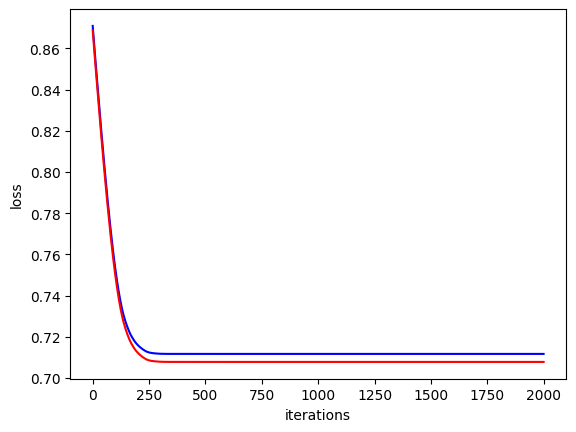

In [ ]:
plt.plot(range(0,iterations),history["train_loss"],'b')
plt.plot(range(0,iterations),history["val_loss"],'r')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

Calculating the loss of the model

In [ ]:
predicted_train=predict(parameters, train_X,nh_array)
predicted_val=predict(parameters, val_X,nh_array)

print("loss of the model on the training data is:", float(compute_loss(train_Y,predicted_train)))
print("loss of the model on the validation data is:", float(compute_loss(val_Y,predicted_val)))

loss of the model on the training data is: 0.7117388248443604
loss of the model on the validation data is: 0.7078518271446228


**Experimenting with different hyperparameter values**

Number of hidden layers:3

Number of neurons in each hidden layer: [1,2,3]

training loss:0.7283483743667603

validation loss:0.7142391800880432

Number of hidden layers:3

Number of neurons in each hidden layer:[2,4,2]

training loss: 0.7283487319946289

validation loss:0.7142395973205566

Number of hidden layers:3

Number of neurons in each hidden layer:[10,5,2]

training loss:0.7283509969711304

validation loss:0.7142421007156372

Number of hidden layers:5

Number of neurons in each hidden layer:[10,5,5,4,3]

training loss: 0.7117388248443604

validation loss: 0.7078518271446228

Number of hidden layers:2

Number of neurons in each hidden layer:[2,1]

training loss: 0.7283496856689453

validation loss: 0.7142412066459656

There isn't much difference in the loss for this model by changing the hyperparameters. But the best set of hyperparameters is

number_of_hidden_layers = 5


number of nodes in hidden layers = [10,5,5,4,3]


In [ ]:
#computing root mean square error
def rmse(Y,Yhat):
    return np.sqrt(np.mean((Y-Yhat)**2))

#getting predictions on test data
def predict_test(parameters,X,nh_array, prob_threshold=0.5):
    Yhat=forward_pass(parameters, X,nh_array)
    predicted_label=Yhat
    return predicted_label


predicted_test=predict_test(parameters, test_X,nh_array)
print("rmse of the model on the test data is:", float(rmse(test_Y,predicted_test)))

rmse of the model on the test data is: 1.1691738367080688


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Computing root mean square error
def rmse(Y, Yhat):
    return np.sqrt(np.mean((Y - Yhat) ** 2))

# Getting predictions on test data
def predict_test(parameters, X, nh_array, prob_threshold=0.5):
    Yhat = forward_pass(parameters, X, nh_array)
    predicted_label = Yhat
    return predicted_label

# predicted_test = predict_test(parameters, test_X, nh_array)
# print("RMSE of the model on the test data is:", float(rmse(test_Y, predicted_test)))

# Linear Regression
regressor = LinearRegression()
regressor.fit(train_X.T, train_Y.T)

# Predict on validation data
predicted_val = regressor.predict(val_X.T)

# Dropping NaN from test_X and test_Y
test_X = test_X.T
test_Y = test_Y.T

# Convert to DataFrame
test_X = pd.DataFrame(test_X)
test_Y = pd.DataFrame(test_Y)

# Drop NaN values
test_X = test_X.dropna()
test_Y = test_Y.loc[test_X.index]

# Convert back to numpy array
test_X = test_X.to_numpy()
test_Y = test_Y.to_numpy()

# Transpose back to original shape
test_X = test_X.T
test_Y = test_Y.T

# Predict on test data
predicted_test = regressor.predict(test_X.T)

# Calculate RMSE
print("RMSE of the model on the validation data is:", float(rmse(val_Y.T, predicted_val)))
print("RMSE of the model on the test data is:", float(rmse(test_Y.T, predicted_test)))

RMSE of the model on the validation data is: 0.2943569001179015
RMSE of the model on the test data is: 0.2999820066362248


rmse of the Neural Network model on the test data is: 1.1691738367080688

rmse of the Linear Regression model on the test data is: 0.2999820066362248


Linear regression seems to work better for this dataset.



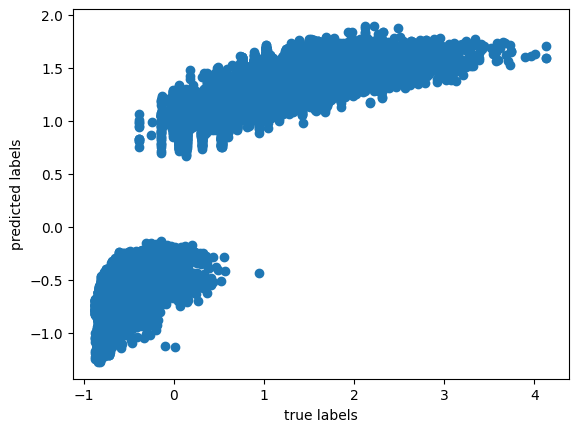

In [ ]:
#plotting predicted vs true labels
plt.scatter(test_Y,predicted_test)
plt.xlabel("true labels")
plt.ylabel("predicted labels")
plt.show()